In [5]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from matplotlib import pyplot as plt
from Classe_sismogramma_v3 import ClasseDataset
# mi servono 10 giga disponibili di RAM (minimo)


def create_identity(x):
    vinput_shape = (None, 160, 1)
    identity = Conv1D(filters=1, kernel_size=1, activation=None, input_shape=vinput_shape[1:])
    x_0 = x
    x_0 = np.expand_dims(x_0, axis=0)
    x_0 = np.expand_dims(x_0, axis=-1)
    aia = identity(x_0)                
    identity.set_weights([np.array([[[1.0]]]), np.array([0.0])])
    return identity

def calc_single_saliency(model, input_k, identity):
    with tf.GradientTape() as tape:
        x_0 = input_k
        x_0 = np.expand_dims(x_0, axis=0)
        x_0 = np.expand_dims(x_0, axis=-1)
        seq = [x_0]

        seq.append(identity(x_0))

        for i in model.layers:
            seq.append(i(seq[-1]))                      
        grad = tape.gradient(seq[-1],seq[1])
    grad = np.array(grad)
    grad = grad[0]
    return (grad, seq[-1])

hdf5_predicting = '/home/silvia/Desktop/Instance_Data/Tre_4s/data_Velocimeter_4s_Normalizzate_New1-1.hdf5'
csv_predicting = '/home/silvia/Desktop/Instance_Data/Tre_4s/metadata_Velocimeter_4s_Normalizzate_New1-1.csv'
Data_predicting = ClasseDataset()
Data_predicting.leggi_custom_dataset(hdf5_predicting, csv_predicting)
lung = len(Data_predicting.sismogramma[0])
semi_amp = 80
pat_tent = '/home/silvia/Documents/GitHub/primoprogetto/Codici/Tentativi/'

tentativo = 52
time_shift = 0                                                                  
figs_name = f"/home/silvia/Desktop/Immagini/Saliency\
/Saliency_InstancePol_tent{tentativo}_shift{time_shift}"                    # Da cambiare tra i  run
saveplot = False

# TODO predict Instance Test (genero dati input rete)
# """
estremi_test = [43, 45, 9.5, 11.8]
xtest = []
y_test_true = []
test_indici = []
for k in range(len(Data_predicting.sismogramma)):
    if estremi_test[0] < Data_predicting.metadata['source_latitude_deg'][k] < estremi_test[1] and estremi_test[2] \
            < Data_predicting.metadata['source_longitude_deg'][k] < estremi_test[3]:
        xtest.append(Data_predicting.sismogramma[k][lung // 2 - semi_amp + time_shift:lung // 2 + semi_amp + time_shift])

        test_indici.append(k)  # TODO salvo posizioni tracce di test
        if Data_predicting.metadata["trace_polarity"][k] == "positive":
            y_test_true.append(1)
        elif Data_predicting.metadata["trace_polarity"][k] == "negative":
            y_test_true.append(0)
Data_predicting = Data_predicting.seleziona_indici(test_indici)
# """

# TODO predict other than Instance polarity
"""
xtest = np.zeros((sample_train, semi_amp * 2))
for k in range(sample_train):
    xtest[k] = Data_predicting.sismogramma[k][lung // 2 - semi_amp + time_shift:lung // 2 + semi_amp + time_shift]
y_test_true = np.array([Data_predicting.metadata["trace_polarity"][_] == "positive" for _ in range(sample_train)])
y_test_true = y_test_true + 0
"""
xtest = np.array(xtest)
print("XSHAPEEEEEEEEEEEE", xtest.shape)

model = keras.models.load_model(pat_tent+str(tentativo)+'/Tentativo_'+str(tentativo)+'.hdf5')
model.summary()


# TODO Da qui inizio a calcolare i gradienti per generare la Saliency map

# Creo layer identità... mi serve perchè non riuscivo a fare gradiente rispetto input (non serve a niente concettualmente)
identi_layer = create_identity(xtest[0])

Saliency_stacked = np.zeros(160)
Saliency_stacked_abs = np.zeros(160)
for input_k in xtest:

    grad_k, output_k = calc_single_saliency(model, input_k, identi_layer)
    #print("caio grad",grad.shape)
    Saliency_single = np.sum(grad_k, axis = 1)                                                      # faccio solamente un reshape da (160,1) a (160,)
    Saliency_single = Saliency_single/ np.max([np.max(Saliency_single),-np.min(Saliency_single)])   # normalizzo per il max assoluto
    Saliency_stacked += Saliency_single                                                             # Saliency map mediata
    Saliency_stacked_abs += np.abs(Saliency_single)                                                 # Saliency map mediata (in valore assoluto)

if saveplot:
    plt.plot(Saliency_stacked)
    plt.savefig(figs_name+"stack_prova.jpg")
    plt.clf()
    plt.plot(Saliency_stacked_abs)
    plt.savefig(figs_name+"stack_abs_prova.jpg")

# TODO urgente
# vedere dove si concentra la rete per quelle sbagliate
# Fare Grad-CAM (simile, adatta al mio caso...)

# Per tirocinio:
# Fai salienci di: tent 52 e tentativo 79, di timeshift tra -20 e 20, passo di 2 e fai una piccola relazione su quello che succede
# (cosa stanno facendo le reti? su che zona si concentrano, limiti utilizzabilità reti?)

XSHAPEEEEEEEEEEEE (8983, 160)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 32)           192       
                                                                 
 dropout (Dropout)           (None, 160, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 157, 64)           8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 128)          0         
 1D)                      

'\nSaliency_stacked = np.zeros(160)\nSaliency_stacked_abs = np.zeros(160)\nfor input_k in xtest:\n\n    grad_k, output_k = calc_single_saliency(model, input_k, identi_layer)\n    #print("caio grad",grad.shape)\n    Saliency_single = np.sum(grad_k, axis = 1)                                                      # faccio solamente un reshape da (160,1) a (160,)\n    Saliency_single = Saliency_single/ np.max([np.max(Saliency_single),-np.min(Saliency_single)])   # normalizzo per il max assoluto\n    Saliency_stacked += Saliency_single                                                             # Saliency map mediata\n    Saliency_stacked_abs += np.abs(Saliency_single)                                                 # Saliency map mediata (in valore assoluto)\n\nif saveplot:\n    plt.plot(Saliency_stacked)\n    plt.savefig(figs_name+"stack_prova.jpg")\n    plt.clf()\n    plt.plot(Saliency_stacked_abs)\n    plt.savefig(figs_name+"stack_abs_prova.jpg")\n'

# CONTROLLO CHE SUCCEDE A TRACCE MISCLASSIFIED

In [ ]:
# Previsione media
Saliency_Erroneous_stacked = np.zeros(160)          # rete in disaccordo
Saliency_Ok_stacked = np.zeros(160)                 # rete in accordo
Saliency_Erroneous_stacked_abs = np.zeros(160)
Saliency_Ok_stacked_abs = np.zeros(160)

for k, input_k in enumerate(xtest):

    grad_k, output_k = calc_single_saliency(model, input_k, identi_layer)
    #print("caio grad",grad.shape)
    Saliency_single = np.sum(grad_k, axis = 1)                                                      # faccio solamente un reshape da (160,1) a (160,)
    Saliency_single = Saliency_single/ np.max([np.max(Saliency_single),-np.min(Saliency_single)])   # normalizzo per il max assoluto

    # print(output_k, y_test_true[k],  output_k-y_test_true[k])

    if abs(output_k-y_test_true[k])<0.5:
        Saliency_Ok_stacked += Saliency_single                                                             
        Saliency_Ok_stacked_abs += np.abs(Saliency_single)
    else:
        Saliency_Erroneous_stacked += Saliency_single                                                             
        Saliency_Erroneous_stacked_abs += np.abs(Saliency_single)


plt.plot(Saliency_Ok_stacked)
plt.savefig(figs_name+"stack_Ok.jpg")
plt.clf()
plt.plot(Saliency_Ok_stacked_abs)
plt.savefig(figs_name+"stack_Ok_abs.jpg")

plt.clf()
plt.plot(Saliency_Erroneous_stacked)
plt.savefig(figs_name+"stack_Erroneous.jpg")
plt.clf()
plt.plot(Saliency_Erroneous_stacked_abs)
plt.savefig(figs_name+"stack_Erroneous_abs.jpg")

In [14]:
# Previsione di singola traccia

from matplotlib.colors import LinearSegmentedColormap
import os
colors = ['#FFFFFF', '#FF0000']
cmap = LinearSegmentedColormap.from_list('my_palette', colors)

path_img = "/home/silvia/Desktop/Immagini/Saliency"
pat_new_dir_saliency = f"{path_img}/SINGLE_SALIENCY_ERRATE_InstancePol_tent{tentativo}_shift{time_shift}_new"
os.mkdir(pat_new_dir_saliency)

err = 0
for k, input_k in enumerate(xtest):

    grad_k, output_k = calc_single_saliency(model, input_k, identi_layer)

    if abs(output_k-y_test_true[k])>=0.5:
       
        #print("caio grad",grad.shape)
        Saliency_single = np.sum(grad_k, axis = 1)                                                      # faccio solamente un reshape da (160,1) a (160,)
        Saliency_single = Saliency_single/ np.max([np.max(Saliency_single),-np.min(Saliency_single)])   # normalizzo per il max assoluto

        # print(output_k, y_test_true[k],  output_k-y_test_true[k])
    
        """plt.plot(Saliency_single)
        plt.savefig(f"{pat_new_dir_saliency}/{k}_Saliency_Errata.jpg")
        plt.clf()
        plt.plot(abs(Saliency_single))
        plt.savefig(f"{pat_new_dir_saliency}/{k}_Saliency_Errata_abs.jpg")
        plt.clf()
        plt.plot(abs(input_k))
        plt.bar(1, width=160, label='',
               color=custom_cmap, align='edge', zorder=1)
        plt.savefig(f"{pat_new_dir_saliency}/{k}_Traccia_Errata.jpg")"""
        
        custom_cmap = [cmap(abs(Saliency_single[_])) for _ in range(160)]
        plt.bar(range(160), 2, bottom=-1, width=1, label='', align='center', zorder=1, color=custom_cmap, alpha = 0.6)
        plt.plot(input_k)
        plt.title(f"Label:{y_test_true[k]}\nPredict:{output_k}")
        plt.savefig(f"{pat_new_dir_saliency}/{k}_Traccia_Errata.jpg")
        plt.clf()

        err += 1 
print("totale tracce errate = ", err)
    

totale tracce errate =  232


<Figure size 640x480 with 0 Axes>

# Modifiche ultime e TEST SCHIFEZZE

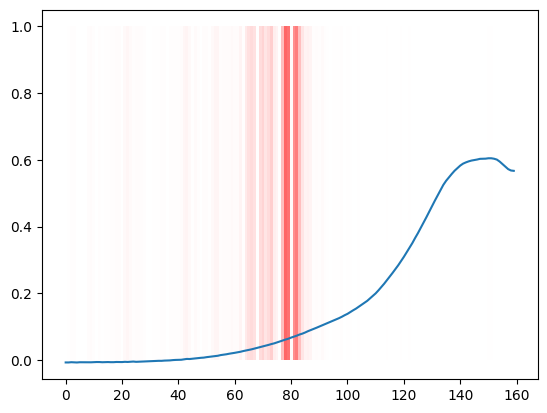

In [44]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#FFFFFF', '#FF0000']
cmap = LinearSegmentedColormap.from_list('my_palette', colors)
custom_cmap = [cmap(abs(Saliency_single[i])) for i in range(160)]
plt.bar(range(160),1 , width=1, label='', align='center', zorder=1, color=custom_cmap, alpha = 0.6)
plt.plot(input_k)

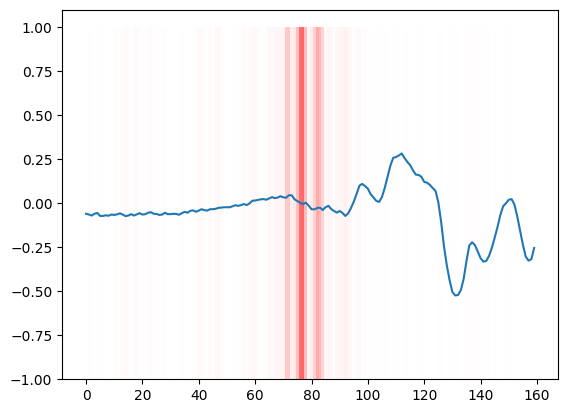

In [10]:
plt.bar(range(160), 2, bottom=-1, width=1, label='', align='center', zorder=1, color=custom_cmap, alpha = 0.6)
plt.plot(input_k)

## Take last layer


2023-09-12 14:12:20.961242: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 32)           192       
                                                                 
 dropout (Dropout)           (None, 160, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 157, 64)           8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 128)          0         
 1D)                                                    

2023-09-12 14:12:23.277751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 14:12:23.862002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6101 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:9e:00.0, compute capability: 7.5


In [26]:
from tensorflow import keras
from keras.layers import Dense

pat_tent = '/home/silvia/Documents/GitHub/primoprogetto/Codici/Tentativi/'
tentativo = 52

model = keras.models.load_model(pat_tent+str(tentativo)+'/Tentativo_'+str(tentativo)+'.hdf5')
model.summary()

newLAy = Dense(1, input_shape = (50,), activation=None)
newLAy.build((None, 50))
a = model.layers[-1].get_weights()
newLAy.set_weights(a)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 32)           192       
                                                                 
 dropout (Dropout)           (None, 160, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 157, 64)           8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 76, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 38, 128)          0         
 1D)                                                    

In [19]:
newLAy.get_weights()

[array([[ 0.49039224],
        [ 0.384341  ],
        [ 0.41083694],
        [ 0.04862231],
        [-0.02759775],
        [-0.37677813],
        [-0.64376855],
        [ 0.1005583 ],
        [-0.05855711],
        [-0.04428053],
        [ 0.66259515],
        [-0.08915199],
        [ 0.05481695],
        [ 0.13428617],
        [ 0.49289533],
        [-0.36115494],
        [-0.5696075 ],
        [-0.47246116],
        [ 0.11497441],
        [ 0.51646125],
        [-0.5942286 ],
        [-0.21574257],
        [ 0.0743133 ],
        [ 0.16244516],
        [-0.1813566 ],
        [-0.50381   ],
        [-0.39372158],
        [ 0.31574962],
        [-0.69435096],
        [-0.39661187],
        [ 0.46370524],
        [ 0.41501167],
        [ 0.06622145],
        [-0.6587927 ],
        [-0.04630092],
        [ 0.4056301 ],
        [-0.05328751],
        [-0.34492797],
        [ 0.6539039 ],
        [ 0.19074883],
        [-0.33402842],
        [ 0.3041477 ],
        [-0.65590763],
        [-0

In [43]:
model.layers[-1](np.array([[i-39.1 for i in range(50)]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6969033]], dtype=float32)>

In [44]:
newLAy(np.array([[i-39.1 for i in range(50)]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8325949]], dtype=float32)>

In [45]:
def sigma(x):
    return np.e**x/(1+np.e**x)

In [48]:
sigma(newLAy(np.array([[i-40.1 for i in range(50)]])))- model.layers[-1](np.array([[i-40.1 for i in range(50)]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>